we are performing web scraping on the website https://www.airlinequality.com/airline-reviews/british-airways.


In [1]:
import pandas as pd
import re
import nltk
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Sometimes needed for lemmatization
nltk.download('averaged_perceptron_tagger')  # For POS tagging in lemmatization
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")
    print

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Prior to boarding a gate a...
1,✅ Trip Verified | I flew from Amsterdam to L...
2,"✅ Trip Verified | First the good news, the clu..."
3,✅ Trip Verified | I have never travelled wit...
4,"✅ Trip Verified | Terrible overall, medium ser..."


now as we can see, all the reviews start with either "trip verified" or "not verified", so our next step should be remove that verification status

In [4]:
df["reviews"] = df["reviews"].str.replace(r"✅ Trip Verified \| ?", "", regex=True)
df["reviews"] = df["reviews"].str.replace(r"❌ Not Verified \| ?", "", regex=True)

df.head()





,reviews
0,Prior to boarding a gate agent seemed to pic...
1,I flew from Amsterdam to Las Vegas with a la...
2,"First the good news, the club suites are such ..."
3,I have never travelled with British airways ...
4,"Terrible overall, medium service and the fligh..."


In [5]:
df.to_csv("BA_reviews.csv")

no that we have successfully scraped the data from the internet and removed the tags, we need to preprocess it.

In preprocessing the data, we will perform certain steps on the data that includes,
Convert text to lowercase.
Remove special characters, numbers, and punctuation.
Tokenize the text into words.
Remove stopwords (common words like "the", "is", "and").
Perform lemmatization to reduce words to their base form.

In [6]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

df["cleaned_reviews"] = df["reviews"].astype(str).apply(clean_text)

next step is to perform sentiment analysis on the data set after preprocessing the data, we use TextBlob or VADER to analyze the data(positive, neutral, or negative)

In [8]:
df["sentiment"] = df["cleaned_reviews"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["sentiment_category"] = df["sentiment"].apply(lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral"))



now, we are displaying sentiment distribution

In [9]:
print(df["sentiment_category"].value_counts())

sentiment_category
Positive    619
Negative    364
Neutral      17
Name: count, dtype: int64


Next step is Topic Modelling(LDA)
Convert text into a document-term matrix using CountVectorizer or TfidfVectorizer and then apply Latent Dirichlet Allocation (LDA) to identify topics in the reviews.

In [11]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df["cleaned_reviews"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def display_topics(model, feature_names, num_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ", [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:  ['flight', 'ba', 'hour', 'day', 'customer', 'told', 'london', 'time', 'service', 'airport']
Topic 1:  ['seat', 'flight', 'british', 'airway', 'service', 'class', 'ba', 'airline', 'business', 'plane']
Topic 2:  ['ba', 'flight', 'hour', 'service', 'staff', 'passenger', 'time', 'airline', 'late', 'delay']
Topic 3:  ['seat', 'flight', 'ba', 'crew', 'good', 'food', 'time', 'drink', 'service', 'cabin']
Topic 4:  ['flight', 'ba', 'good', 'food', 'seat', 'time', 'class', 'business', 'service', 'crew']


we will now generate a Word Cloud in which we will visualize the most frequently used words in the reviews.

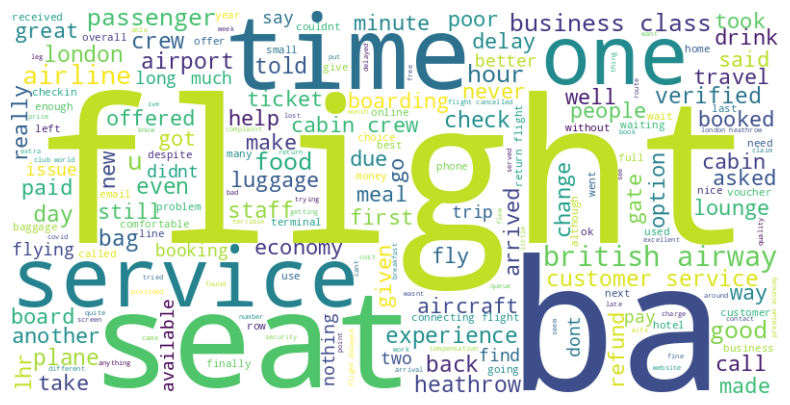

In [12]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df["cleaned_reviews"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()